#  Index Predictor Definition and Building

In [9]:
# basic
import sys
import os

# common
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pickle

#lib
from lib.plots_base import basemap_ibtracs,basemap_ibtracs_ncep, basemap_var, basemap_scatter, axplot_basemap, basemap_scatter_both, plot_target_area,plot_predictor_grid,plot_target_area_plain
from lib.plots_tcs import get_storm_color, get_category, Plot_DWTs_tracks
from lib.plots_aux import data_to_discret, colors_dwt
from lib.extract_tcs import Extract_Rectangle, dwt_tcs_count, Extract_Rectangle_ncep,Extract_Rectangle_ncep_dataset
from lib.predictor_definition_building import *

import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image

In [43]:
#path to your daily mean SST and MLD data
path_sst = r'/media/administrador/SAMSUNG/seasonal_forecast/data/SST/'
path_mld = r'/media/administrador/SAMSUNG/seasonal_forecast/data/CFS/ocnmld/'
path_p = r'/home/administrador/Documentos/seasonal/seasonal_forecast/new/'

<br>

## Spatial and temporal domain




**The predictor area spans around part of the Australian eastern coast, with the Great Barrier Reef as the target zone, from latitude 9º to 26º South and from longitude 140º to 163º West; far enough to be able to identify regional as well as local patterns. The calibration period (time domain) is defined from 1982 to 2019.**

In [22]:
lo_SP, la_SP = [130,175], [-36,0]

# predictor area
lo_area = [140, 163]
la_area = [-26, -9]

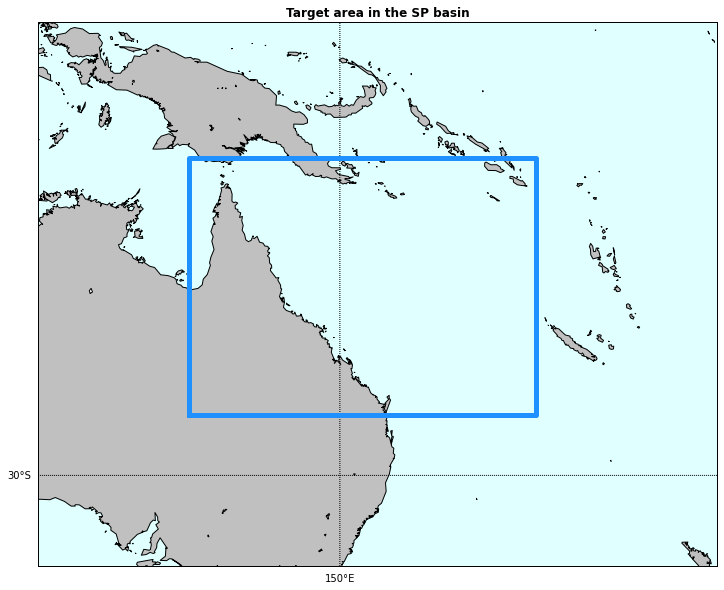

In [3]:
fig_target_area = plot_target_area_plain(lo_SP,la_SP,rectangle=[lo_area[0], lo_area[1], la_area[0], la_area[1]])

<br>

**The variables required for the methodology are downloaded from the databases:**

+ **Predictand**: Tropical cyclones tracks from IBTrACs, for the minimum pressure point.

+ **Predictor**: NOAA 1/4º daily Optimum Interpolation Sea Surface Temperature (SST) and Mixed Layer Depth (MLD) from the NCEP Climate Forecast System Reanalysis (CFSR).



**For the predictand variable data, two TCs databases are explored, the historical database from IBTrACS Version 4.0 and the synthetic database Version 6.3 from (provided by Emanuel).**

### Historical database (IBTrACS)



In [21]:
# ibtracs v4 dictionary
d_vns_h = {
    'longitude': 'lon',
    'latitude': 'lat',
    'time': 'time',
    'pressure': 'wmo_pres',}

In [24]:
path_st = r'/home/administrador/Documentos/'
xds_ibtracs, xds_SP = storms_sp(path_st)

All basins storms:  13481
SP basin storms:    1130 



In [50]:
# extract rectangle, 772 a 780
TCs_rect_hist_tracks = Extract_Rectangle(xds_SP, lo_area[0], lo_area[1], la_area[0], la_area[1], d_vns_h) 
TCs_rect_hist_tracks

<xarray.Dataset>
Dimensions:           (date_time: 360, quadrant: 4, storm: 646)
Coordinates:
    time              (storm, date_time) datetime64[ns] ...
    lat               (storm, date_time) float32 -19.2 -19.29 -19.39 ... nan nan
    lon               (storm, date_time) float32 151.8 151.7 151.6 ... nan nan
  * storm             (storm) int64 0 2 3 6 7 8 ... 1119 1123 1124 1127 1129
Dimensions without coordinates: date_time, quadrant
Data variables: (12/147)
    numobs            (storm) float32 13.0 29.0 53.0 45.0 ... 9.0 19.0 35.0 45.0
    sid               (storm) |S13 b'1898034S19152' ... b'2021060S17147'
    season            (storm) float32 1.898e+03 1.899e+03 ... 2.021e+03
    number            (storm) int16 4 6 9 5 10 4 3 13 ... 23 10 19 21 2 5 10 18
    basin             (storm, date_time) |S2 b'SP' b'SP' b'SP' ... b'' b'' b''
    subbasin          (storm, date_time) |S2 ...
    ...                ...
    reunion_gust      (storm, date_time) float32 ...
    reunion_gust_per  (storm, date_time) float32 ...
    usa_seahgt        (storm, date_time) float32 ...
    usa_searad        (storm, date_time, quadrant) float32 ...
    storm_speed       (storm, date_time) float32 ...
    storm_dir         (storm, date_time) float32 ...
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

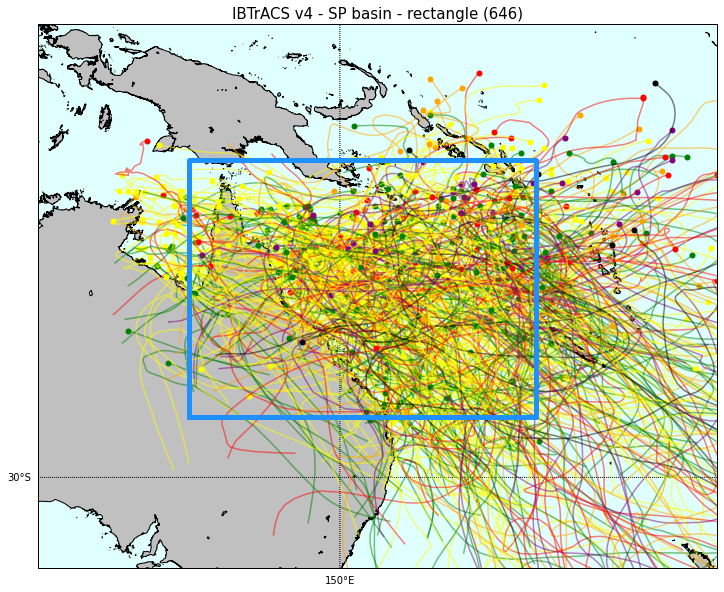

In [51]:
# plot
title = 'IBTrACS v4 - SP basin - rectangle ({0})'.format(TCs_rect_hist_tracks.storm.size)
basemap_ibtracs(lo_SP[0], lo_SP[1], la_SP[0], la_SP[1], 
                TCs_rect_hist_tracks, d_vns, title,
               rectangle=[lo_area[0], lo_area[1], la_area[0], la_area[1]]);

In [26]:
df0 = df_pressures(xds_ibtracs)
df0[6000:6010]

st                          time         lon        lat    pres
6000  9833 1987-02-12 12:00:00.000040448  139.125000 -15.225000   970.0
6001  9833 1987-02-12 18:00:00.000040448  139.817963 -15.790068   970.0
6002  9833 1987-02-13 00:00:00.000040448  140.160004 -16.719999   970.0
6003  9833 1987-02-13 06:00:00.000040448  140.032623 -17.892567   980.0
6004  9833 1987-02-13 12:00:00.000040448  139.699997 -19.200003   996.0
6005  9833 1987-02-13 18:00:00.000040448  139.480362 -20.108568   998.0
6006  9833 1987-02-14 00:00:00.000040448  139.399994 -21.100000  1001.0
6007  9835 1987-02-07 12:00:00.000040448  161.800003 -13.050001   990.0
6008  9835 1987-02-07 18:00:00.000040448  163.449997 -13.150000   995.0
6009  9835 1987-02-08 00:00:00.000040448  166.242844 -14.371429   997.0

**For the calibration period the points with pressure, SST and MLD data in the target area are kept.**

In [51]:
df = df_p_sst_mld(df0,path_sst,path_mld,lo_area[0], lo_area[1], la_area[0], la_area[1])

Start time:  2021-05-07 13:57:08.812397
End time:    2021-05-07 14:02:23.984045 



In [44]:
dfh = dfh.drop(df.index[2846:]) #years of the calibration period
#dfh.to_pickle(path_p+'df_coordinates_pmin_sst_mld_2019_CR.pkl')
dfh

st                          time         lon        lat    pres  \
0      9246 1981-12-22 00:00:00.000040448  162.085724 -17.485714   955.0   
1      9246 1981-12-22 12:00:00.000040448  162.000000 -18.250000   940.0   
2      9246 1981-12-23 00:00:00.000040448  162.300003 -18.924999   925.0   
3      9246 1981-12-27 12:00:00.000040448  163.000000 -24.999998   997.0   
4      9247 1981-12-21 12:00:00.000040448  162.500000 -16.500000   965.0   
...     ...                           ...         ...        ...     ...   
2841  13268 2019-05-14 18:00:00.000039936  145.100006 -13.300000  1007.0   
2842  13268 2019-05-14 21:00:00.000039936  144.465012 -13.019837  1007.0   
2843  13268 2019-05-15 00:00:00.000039936  143.800003 -12.799999  1007.0   
2844  13268 2019-05-15 12:00:00.000039936  140.800003 -12.100000  1007.0   
2845  13268 2019-05-15 15:00:00.000039936  140.023407 -11.887744  1007.0   

            sst        mld  
0     28.090000  28.083334  
1     28.000000  21.333334  
2     26.170000  27.000000  
3     23.519999  28.708332  
4     27.869999  32.375000  
...         ...        ...  
2841  26.959999  61.875000  
2842  27.219999  98.416664  
2843  27.160000  90.416664  
2844  28.709999  58.208336  
2845  28.139999  66.458336  

[2846 rows x 7 columns]

<br>

### Synthetic database (Provided by Emanuel)



  **Original database:**

In [3]:
ds = xr.open_dataset(r'/home/administrador/Documentos/seasonal/ncep_tracks.nc')
ds

<xarray.Dataset>
Dimensions:     (intersect: 10, storm: 3900, time: 400, year: 39)
Dimensions without coordinates: intersect, storm, time, year
Data variables: (12/47)
    daystore    (storm, time) float64 ...
    hourstore   (storm, time) float64 ...
    latstore    (storm, time) float64 ...
    longstore   (storm, time) float64 ...
    monthstore  (storm, time) float64 ...
    pstore      (storm, time) float64 ...
    ...          ...
    model       |S4 ...
    shape       |S4 ...
    vcrit       |S2 ...
    polytype    |S4 ...
    frac        float64 ...
    freq        float64 ...

In [23]:
# ibtracs v4 dictionary
d_vns_s = {
    'longitude': 'longstore',
    'latitude': 'latstore',
    'pressure': 'pstore',}


In [19]:
tc = Extract_Rectangle_ncep(ds, lo_area[0], lo_area[1], la_area[0], la_area[1], d_vns_s) 

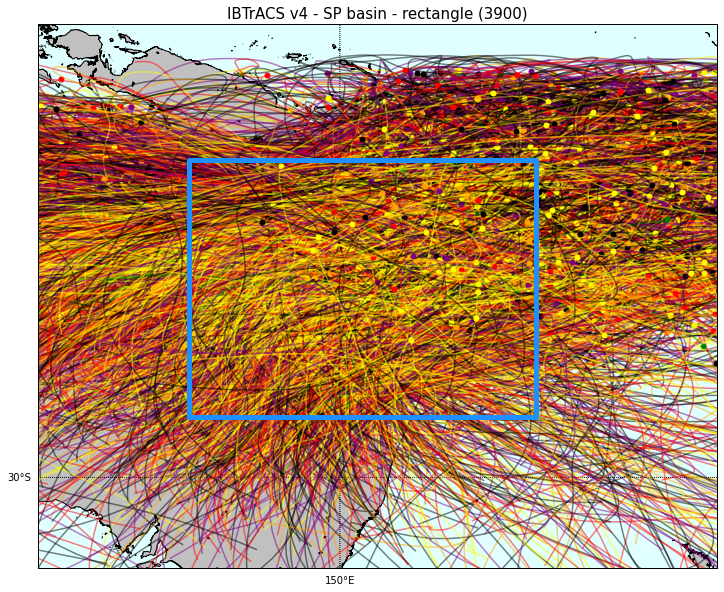

In [204]:
# plot
title = 'IBTrACS v4 - SP basin - rectangle ({0})'.format(tc.storm.size)
basemap_ibtracs_ncep(list_k,lo_SP[0], lo_SP[1], la_SP[0], la_SP[1], 
                tc, d_vns, title,
               rectangle=[lo_area[0], lo_area[1], la_area[0], la_area[1]]);

In [308]:
df0 = df_pressures_ncep(tc,list_k,d_vns)
#df0.to_netcdf(path_p+'df_coordinates_pmin_sst_mld_2019_CR_ncep_original.pkl')

In [30]:
df0 = pd.read_pickle(path_p+'df_coordinates_pmin_sst_mld_2019_CR_ncep_original.pkl')
df0

st      lon     lat     pres                time
0          0  156.874  -7.617  1008.68 1979-09-30 12:00:00
1          0  156.985  -7.394  1008.72 1979-09-30 14:00:00
2          0  157.108  -7.172  1008.66 1979-09-30 16:00:00
3          0  157.244  -6.954  1008.53 1979-09-30 18:00:00
4          0  157.395  -6.741  1008.34 1979-09-30 20:00:00
...      ...      ...     ...      ...                 ...
491568  3899  158.164 -27.030  1002.62 2017-01-14 14:00:00
491569  3899  158.219 -27.067  1002.93 2017-01-14 16:00:00
491570  3899  158.270 -27.110  1003.22 2017-01-14 18:00:00
491571  3899  158.315 -27.158  1003.49 2017-01-14 20:00:00
491572  3899  158.353 -27.210  1003.75 2017-01-14 22:00:00

[491573 rows x 5 columns]

**Prepocessing of the original synthetic database to have the same format and structure of the IBTrACs database.**


In [32]:
ds_syn = ncep_dataset(ds, df0, lo_area[0], lo_area[1], la_area[0], la_area[1], d_vns) 
ds_syn.to_netcdf(path_p+'ncep.nc')

**Resultant database:**

In [16]:
ds_syn = xr.open_dataset(path_p+'ncep.nc')
ds_syn

<xarray.Dataset>
Dimensions:    (date_time: 400, storm: 3900)
Coordinates:
  * date_time  (date_time) int64 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399
  * storm      (storm) int64 0 1 2 3 4 5 6 ... 3894 3895 3896 3897 3898 3899
Data variables:
    lat        (storm, date_time) float64 ...
    lon        (storm, date_time) float64 ...
    time       (storm, date_time) datetime64[ns] ...
    pres       (storm, date_time) float64 ...

<br>

**For the calibration period the points with pressure, SST and MLD data in the target area are kept. Although there are clear and signficant differences between both databases, as it could be observed when exploring the relationship between the large-scale predictors (AWT and MJO) and the TC activity and the TCs categories and trajectories.**

In [316]:
dfs = df_p_sst_mld(dfn,path_sst,path_mld,lo_area[0], lo_area[1], la_area[0], la_area[1])
dfs.to_pickle(path_p+'df_coordinates_pmin_sst_mld_2019_CR_ncep.pkl')

Start time:  2021-05-17 12:54:43.069726
End time:    2021-05-17 14:46:45.930885 



In [37]:
dfs = pd.read_pickle(path_p+'df_coordinates_pmin_sst_mld_2019_CR_ncep.pkl')
dfs

st      lon     lat     pres                time        sst  \
27173    202  149.448 -12.226  1008.75 1981-12-06 06:00:00  29.449999   
27174    202  149.845 -12.188  1008.79 1981-12-06 08:00:00  29.330000   
27175    202  150.247 -12.135  1008.73 1981-12-06 10:00:00  29.320000   
27176    202  150.647 -12.069  1008.59 1981-12-06 12:00:00  29.090000   
27177    202  151.044 -11.987  1008.41 1981-12-06 14:00:00  29.289999   
...      ...      ...     ...      ...                 ...        ...   
491533  3899  153.750 -25.487   994.12 2017-01-11 16:00:00  27.689999   
491534  3899  153.813 -25.601   994.19 2017-01-11 18:00:00  27.680000   
491535  3899  153.888 -25.712   994.26 2017-01-11 20:00:00  27.680000   
491536  3899  153.972 -25.821   994.32 2017-01-11 22:00:00  27.619999   
491537  3899  154.059 -25.928   994.38 2017-01-12 00:00:00  27.789999   

              mld  
27173   25.166666  
27174   28.416666  
27175   30.791668  
27176   29.666666  
27177   30.499998  
...           ...  
491533  55.333332  
491534  59.708332  
491535  59.708332  
491536  59.708332  
491537  58.499996  

[210086 rows x 7 columns]

<br>

**Joint dataset of both synthetic and historical databases, SST and MLD data in the target area are kept.**

In [69]:
dft = pd.concat([dfh,dfs])
dft.to_pickle(path_p+'df_coordinates_pmin_sst_mld_2019_CR_totalok.pkl')

In [42]:
dft = pd.read_pickle(path_p+'df_coordinates_pmin_sst_mld_2019_CR_totalok.pkl')
dft

st                          time         lon        lat    pres  \
0       9246 1981-12-22 00:00:00.000040448  162.085724 -17.485714  955.00   
1       9246 1981-12-22 12:00:00.000040448  162.000000 -18.250000  940.00   
2       9246 1981-12-23 00:00:00.000040448  162.300003 -18.924999  925.00   
3       9246 1981-12-27 12:00:00.000040448  163.000000 -24.999998  997.00   
4       9247 1981-12-21 12:00:00.000040448  162.500000 -16.500000  965.00   
...      ...                           ...         ...        ...     ...   
491533  3899 2017-01-11 16:00:00.000000000  153.750000 -25.487000  994.12   
491534  3899 2017-01-11 18:00:00.000000000  153.813000 -25.601000  994.19   
491535  3899 2017-01-11 20:00:00.000000000  153.888000 -25.712000  994.26   
491536  3899 2017-01-11 22:00:00.000000000  153.972000 -25.821000  994.32   
491537  3899 2017-01-12 00:00:00.000000000  154.059000 -25.928000  994.38   

              sst        mld  
0       28.090000  28.083334  
1       28.000000  21.333334  
2       26.170000  27.000000  
3       23.519999  28.708332  
4       27.869999  32.375000  
...           ...        ...  
491533  27.689999  55.333332  
491534  27.680000  59.708332  
491535  27.680000  59.708332  
491536  27.619999  59.708332  
491537  27.789999  58.499996  

[212932 rows x 7 columns]

**All computed dataframes: from historical data, synthetic data and from joining both databases:**

In [43]:
# load data
dfh = pd.read_pickle(path_p+'df_coordinates_pmin_sst_mld_2019_CR.pkl')
dfs = pd.read_pickle(path_p+'df_coordinates_pmin_sst_mld_2019_CR_ncep.pkl')
dft = pd.read_pickle(path_p+'df_coordinates_pmin_sst_mld_2019_CR_totalok.pkl')

<br>

## Predictor grid and data processing




**The historical datasets are interpolated into the a 1/2º grid resolution, defining this way the grid for the predictor in the target area.**


In [45]:
#predictor grid
lop = 139.75
lop2 = 165
lap = -8.25
lap2 = -28
delta = 2

In [95]:
lo_sel = np.arange(lop, lop2, delta)
la_sel = np.arange(lap, lap2, -delta)

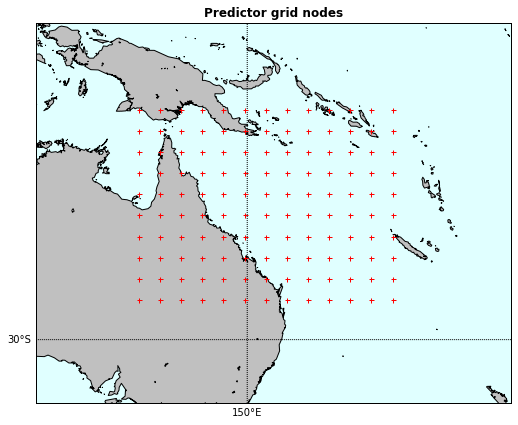

In [18]:
fig_predictor_grid = plot_predictor_grid(2,lop,lop2,lap,lap2,lo_SP,la_SP)

<br>

**MLD, SST and Pmin data plotted after preprocessing (left) and the same data after discretization in intervals of 0.5 m and 0.5ºC for MLD and SST respectively (right):**

**Historical database**

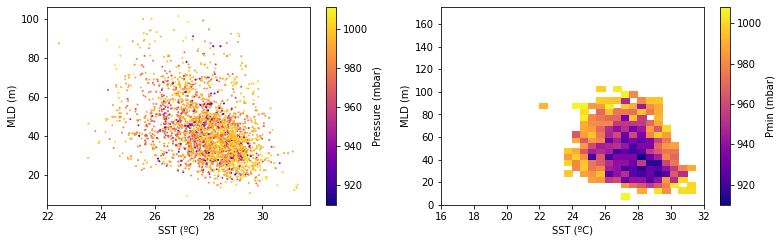

In [376]:
plot_sst_mlp_pmin_cali(df)

**Synthetic database**

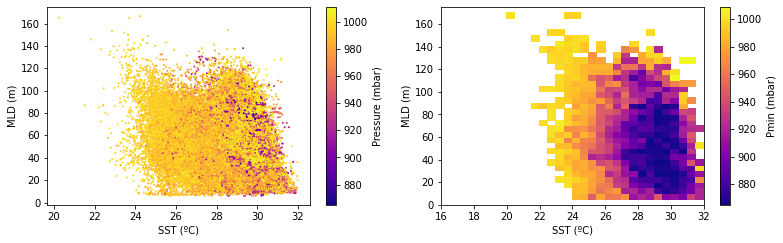

In [96]:
plot_sst_mlp_pmin_cali(df)

**Both databases**

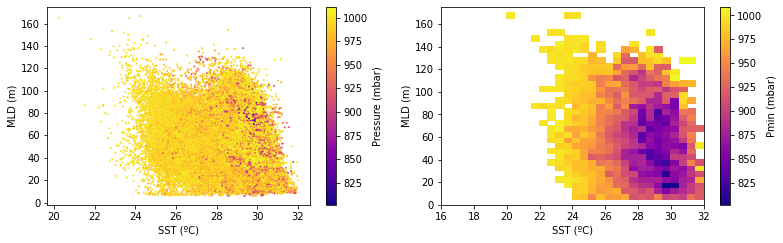

In [30]:
plot_sst_mlp_pmin_cali(dft)

<br>

## Index definition and computation



**The historic datasets are combined into the tailor-made index predictor. It is built from the combination of SST-MLD-Pmin of the coordinate dataset previously generated. For simplicity the index will range from 0 to 1, so the pressure range is rescaled in this interval, accounting for the pressure limits of the record.**
<br>


In [39]:
# discretization: 0.5ºC (SST), 5m (MLD)
xx,yy,zz = data_to_discret(df['sst'].values, df['mld'].values, 0.5, 5, df['pres'].values, 15, 32, 0, 175, option='min')

# index function
index = zz
fmin, fmax = np.nanmin(zz), np.nanmax(zz)
index_zz = (fmax - index) / (fmax-fmin)

# remove nan
index_zz[np.isnan(index_zz)] = 0

<br>

**The index predictor function:** <br>
    


```{math}
:label: eq_index

index_{i} = (P_{max} + P_{i}) / (P_{max} - P_{min})
```

<br>

**The resultant tailor-made index predcitor plotted in the MLD-SST space:**

**<u>Historical database (chosen)</u>**

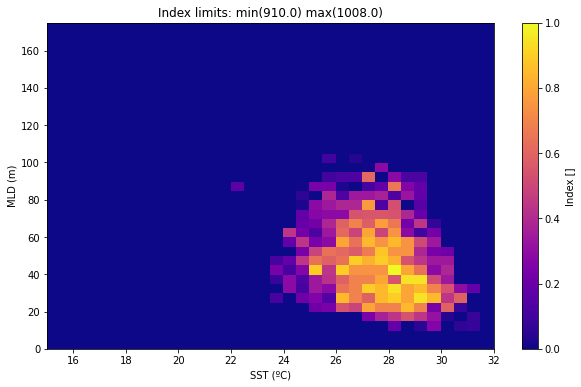

In [21]:
fig_index = plot_index(xx,yy,zz,index_zz)

**Synthetic database**

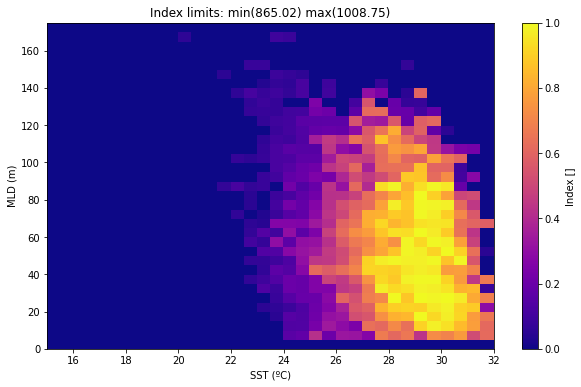

In [98]:
fig_index_t = plot_index(xx,yy,zz,index_zz)

**Both databases**

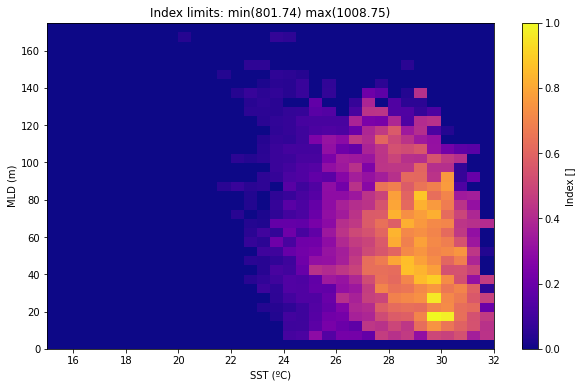

In [32]:
fig_index_t = plot_index(xx,yy,zz,index_zz)

<br>
<br>

**Final dataset including all the variable and the index predictor values in the predictor grid. It is built based on the index previously obtained. In this case it was decided to use the historical database based tailor-made index predictor.**

In [41]:
path_slp = r'/media/administrador/SAMSUNG/seasonal_forecast/data/CFS/'
path_pp = r'/home/administrador/Documentos/pratel/'
path_trmm = r'/home/administrador/Documentos/TRMM_daily/'

In [46]:
xs = ds_index_sst_mld_calibration(path_sst,path_mld,df,lop,lop2,lap,lap2,delta)

Start time:  2021-05-19 13:01:04.359730
End   time:  2021-05-19 13:01:17.881323
Merge time:  2021-05-19 13:06:52.088373 

<xarray.Dataset>
Dimensions:  (lat: 10, lon: 13, time: 13879)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2019-12-31
  * lat      (lat) float64 -8.25 -10.25 -12.25 -14.25 ... -22.25 -24.25 -26.25
  * lon      (lon) float64 139.8 141.8 143.8 145.8 ... 157.8 159.8 161.8 163.8
Data variables:
    index    (time, lat, lon) float64 0.0 0.0 0.07143 ... 0.898 0.0 0.2857
    sst      (time, lat, lon) float32 29.57 nan 31.0 30.21 ... 25.22 23.62 24.38
    dbss     (time, lat, lon) float32 nan nan 13.83 31.0 ... 44.62 50.21 39.08
    mask     (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 0.0 ... 0.0 0.0 0.0 0.0 0.0


In [47]:
xs_f = ds_index_sst_mld_slp_pp_calibration(path_pp,path_slp,xs,lop,lop2,lap,lap2,delta)

Start time:  2021-05-19 13:07:02.469564
End   time:  2021-05-19 13:07:03.407022
Merge time:  2021-05-19 13:10:10.355473 



In [26]:
xs_trmm = ds_trmm(path_trmm,lop,lop2,lap,lap2,delta)

Start time:  2021-05-09 17:37:49.001553
End   time:  2021-05-09 17:37:49.198931
Merge time:  2021-05-09 17:37:56.799949 

